# Deep Learning HW2 - Problem 1
### Ehsan Sharifian 400201529

---



## part a

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda


training_data = datasets.FashionMNIST(
    root="data", 
    train=True, 
    download=True,  
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),value=1))                          
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),value=1))
)

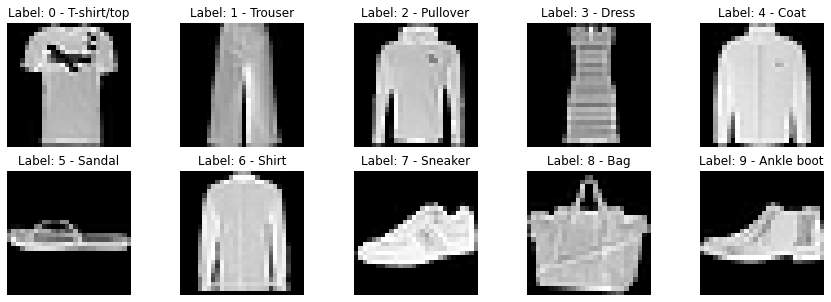

In [ ]:
import matplotlib.pyplot as plt

# Choosing random data in each class and visualizing it
plt.figure(figsize=(15, 5))
for i in range(len(training_data.classes)):
  index_tensor = (training_data.targets == i).nonzero(as_tuple=True)[0]
  random_index = index_tensor[torch.randint(len(index_tensor), (1,))][0]
  img, label = training_data[random_index]
  plt.subplot(2, 5, i+1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Label: {i} - {training_data.classes[i]}")
  plt.axis(False)
plt.show()

## part b

In [ ]:
def SoftMax(X):
    return torch.exp(X) / (torch.exp(X).sum(axis=1).reshape(-1,1))

def ReLU(X):
    return X * (X > 0)

class FullyConnectedLayer():
    def __init__(self, weights, biases, Activation=ReLU):
        self.weights = weights
        self.biases = biases
        self.Activation = Activation

    def output(self, X_Batch):
        output = self.Activation(X_Batch.matmul(self.weights) + self.biases)
        return output

In [ ]:
def My_Flatten(X_Batch, input_size):
    return X_Batch.reshape(-1, input_size).float()

def Weight_Initialization(input_size,output_size):
    return 1e-2*torch.randn((input_size,output_size), requires_grad=True)

def Bias_Initialization(size):
    return 1e-2*torch.randn((1,size), requires_grad=True)

class My_Network():
    def __init__(self):
        self.input_size = 28*28
        self.output_size = 10
        self.leyer_num = 3
        neuron_number_1 = 20
        neuron_number_2 = 20
        self.flatten = My_Flatten
        self.linear1 = FullyConnectedLayer(Weight_Initialization(self.input_size,neuron_number_1),Bias_Initialization(neuron_number_1),ReLU)
        self.linear2 = FullyConnectedLayer(Weight_Initialization(neuron_number_1,neuron_number_2),Bias_Initialization(neuron_number_2),ReLU)
        self.linear3 = FullyConnectedLayer(Weight_Initialization(neuron_number_2,self.output_size),Bias_Initialization(self.output_size),SoftMax)
        self.layers = [self.linear1,self.linear2,self.linear3]

    def model(self, x):
        x = self.flatten(x,self.input_size)
        x = self.linear1.output(x)
        x = self.linear2.output(x)
        probs = self.linear3.output(x)
        return probs

network = My_Network()

## Part c

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [ ]:
def One_Hot_Transform(label_list):
  one_hot_list = []
  for i in range(len(label_list)):
    one_hot_list.append(torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=label_list[i],value=1))
    
  return torch.stack(one_hot_list,dim=0)


class My_DataLoader():
  def __init__(self,data, batch_size=64, shuffle=True):
    self.size = len(data)
    if (shuffle):
      index_permuted = torch.randperm(self.size)
      X_permuted = data.data[index_permuted]
      y_permuted = data.targets[index_permuted] 
    batch_number = int(np.ceil(len(data)/batch_size))
    DL = []
    for batch in range(batch_number):
      X = X_permuted[batch * batch_size : (batch + 1) * batch_size if  batch!=batch_number else self.size]
      y = One_Hot_Transform(y_permuted[batch * batch_size : (batch + 1) * batch_size if  batch!=batch_number else self.size])
      DL.append([X,y])

    self.data = DL

def Cross_Entropy(prob1,prob2):
  return -torch.sum(torch.log(prob1) * prob2) / prob2.shape[0]

In [ ]:
def train_loop(dataloader, network, loss_fn, lr):
    size = dataloader.size
    num_batches = len(dataloader.data)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader.data):
        # Compute prediction and loss
        pred = network.model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

        for layer in network.layers:
          layer.weights.retain_grad()
          layer.biases.retain_grad()

        # Backpropagation
        loss.backward(retain_graph=True)
        for layer in network.layers:
          layer.weights = layer.weights - lr * layer.weights.grad
          layer.biases = layer.biases - lr * layer.biases.grad
        
        if batch % 200 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def test_loop(dataloader, network, loss_fn):
    size = dataloader.size
    num_batches = len(dataloader.data)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader.data:
            pred = network.model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
train_dataloader = My_DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = My_DataLoader(test_data, batch_size, shuffle=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, network, Cross_Entropy, learning_rate)
    test_loop(test_dataloader, network, Cross_Entropy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301496  [    0/60000]
loss: 1.374265  [12800/60000]
loss: 0.734374  [25600/60000]
loss: 0.799095  [38400/60000]
loss: 0.698600  [51200/60000]
Train Error: 
 Accuracy: 58.1%, Avg loss: 1.146353 

Test Error: 
 Accuracy: 71.5%, Avg loss: 0.753187 

Epoch 2
-------------------------------
loss: 0.791250  [    0/60000]
loss: 0.631461  [12800/60000]
loss: 0.498604  [25600/60000]
loss: 0.637960  [38400/60000]
loss: 0.528912  [51200/60000]
Train Error: 
 Accuracy: 77.7%, Avg loss: 0.626143 

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.610513 

Epoch 3
-------------------------------
loss: 0.691696  [    0/60000]
loss: 0.493405  [12800/60000]
loss: 0.397181  [25600/60000]
loss: 0.585652  [38400/60000]
loss: 0.483742  [51200/60000]
Train Error: 
 Accuracy: 81.6%, Avg loss: 0.524111 

Test Error: 
 Accuracy: 79.2%, Avg loss: 0.560266 

Epoch 4
-------------------------------
loss: 0.621878  [    0/60000]
loss: 0.400761  [12800/60000]
loss: 0.347006 

In [ ]:
# saving
torch.save(network, 'network.pth')

## Part D

In [ ]:
test_loop(test_dataloader, network, Cross_Entropy)

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.455704 



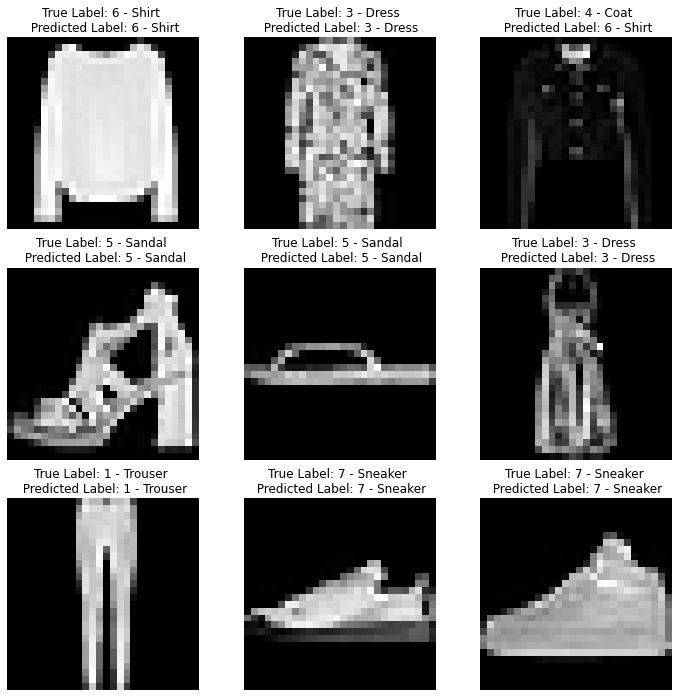

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
  index = torch.randint(len(test_data), (1,))[0]
  img, label = test_data[index]
  plt.subplot(3, 3, i+1)
  plt.imshow(img.squeeze(), cmap="gray")
  true_label = test_data.targets[index]
  true_class = test_data.classes[true_label]
  predicted_label = network.model(test_data.data[index]).argmax()
  predicted_class = test_data.classes[predicted_label]
  plt.title(f"True Label: {true_label} - {true_class} \n Predicted Label: {predicted_label} - {predicted_class}")
  plt.axis(False)
plt.show()